In [1]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

Loading required package: Matrix
Loading required package: grid


# Readability

In this notebook, we document our various steps taken to study the effect of the overall length of a session on the readability (flesch_kincaid_grade) of the very first comment. Note that we only do this on a sample of 1 mio. data points here.

In [2]:
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [3]:
nrow(data)

[1] 1000000

## Data inspection

We start by getting a better feeling of our data.

We limit the data to only consider the first comment of each session.

In [4]:
idx = data$session_index==1

In [5]:
data_first = data[idx,]

In [6]:
nrow(data_first)

[1] 502586

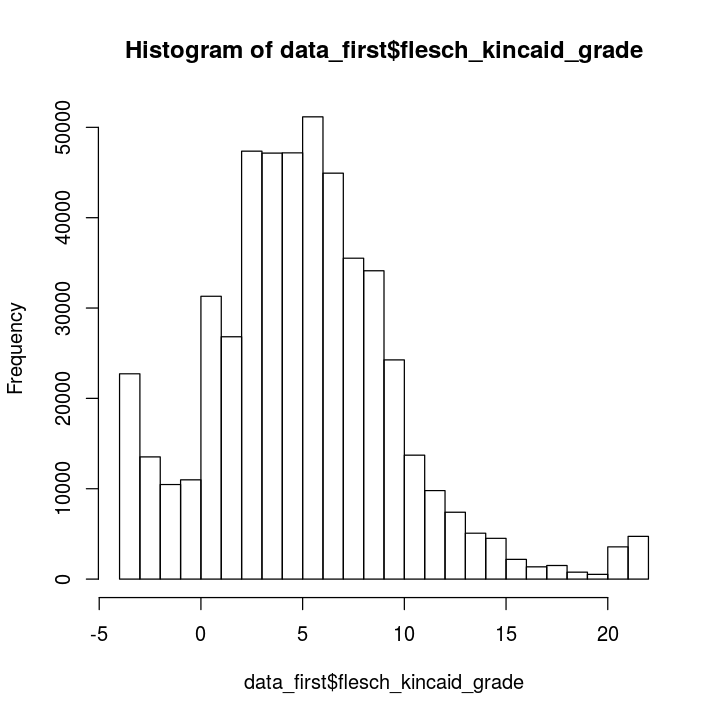

In [15]:
hist(data_first$flesch_kincaid_grade)

## Regression model

We use mixed-effects models where in the most basic form (that we analyze in this notebook), we are interested in studying flesch_kincaid_grade ~ 1 + session_comments + (1|author) where flesch_kincaid_grade is the readability of the first comment, session_comments refers to the session length and author represents the redditor username.

### Linear mixed-effects regression

We start with a linear mixed-effects model.

In [22]:
m_lmer = lmer(flesch_kincaid_grade~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [20]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments + (1 | author)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 2963822  2963866 -1481907  2963814   502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7703 -0.5699 -0.0408  0.5158  3.9417 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.325   1.525   
 Residual             19.076   4.368   
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                 Estimate Std. Error t value
(Intercept)      5.066388   0.007827   647.3
session_comments 0.006316   0.002022     3.1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.505

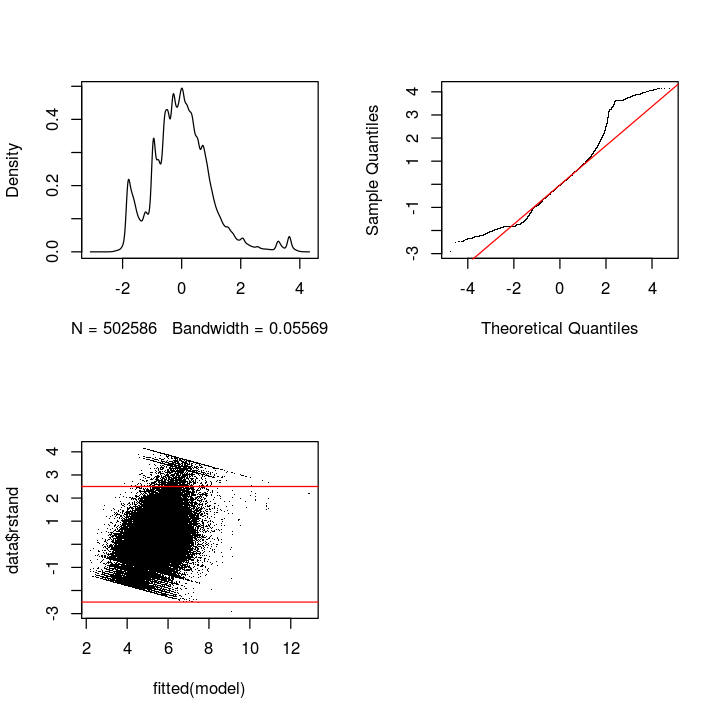

In [21]:
mcp.fnc(m_lmer)

While not perfect, the residuals do not look to bad for large data here. The deviations from normality might be explained by the peaks in data at both ends of the distribution (large and low readability). Let us quickly try two transformations on the outcome (sqrt and log) for which we first set the outcome positive by adding a constant.

In [13]:
min(data_first$flesch_kincaid_grade)
data_first$flesch_kincaid_grade.t = data_first$flesch_kincaid_grade + 4.4

[1] -3.4

### Linear mixed-effects regression (transform)

In [23]:
m_lmer_log = lmer(log(flesch_kincaid_grade.t)~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [24]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(flesch_kincaid_grade.t) ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
 982668.2  982712.7 -491330.1  982660.2    502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5593 -0.2780  0.1997  0.5819  2.3651 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.04342  0.2084  
 Residual             0.37188  0.6098  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      2.0869745  0.0010896  1915.3
session_comments 0.0014830  0.0002817     5.3

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.505

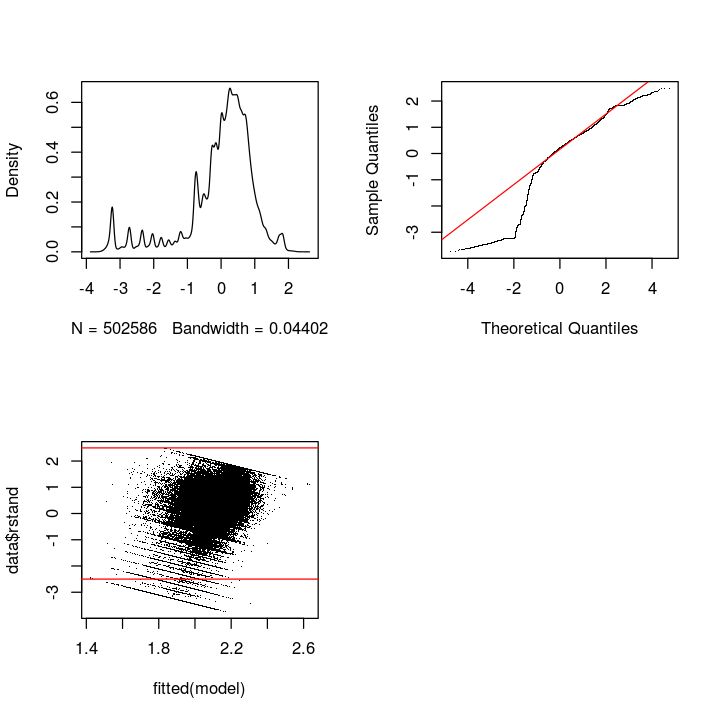

In [25]:
mcp.fnc(m_lmer_log)

Does not really look better.

In [26]:
m_lmer_sqrt = lmer(sqrt(flesch_kincaid_grade.t)~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [27]:
summary(m_lmer_sqrt)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: sqrt(flesch_kincaid_grade.t) ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1194228.7 1194273.2 -597110.4 1194220.7    502582 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.03745 -0.45964  0.08407  0.58241  3.12367 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.07056  0.2656  
 Residual             0.56243  0.7500  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      2.9710165  0.0013466  2206.3
session_comments 0.0015057  0.0003477     4.3

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.504

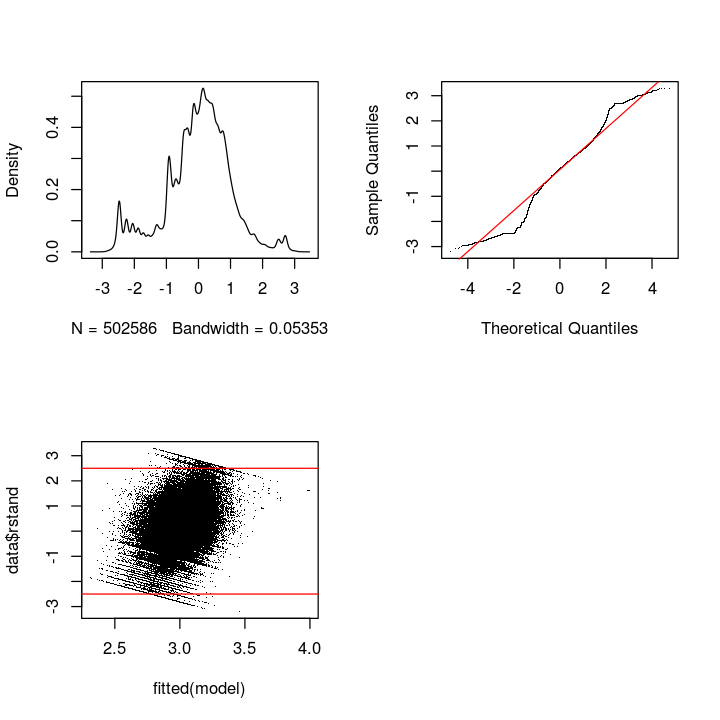

In [28]:
mcp.fnc(m_lmer_sqrt)

Looks quite similar to the non-transformed.

Let us focus on a potentially more appropriate Gamma generalized linear mixed-effects model next though.

### Gamma GLMER

Let us model the data with a Gamma GLMER using a log link.

In [34]:
m_gamma = glmer(flesch_kincaid_grade.t~1+session_comments+(1|author),data=data_first,family=Gamma(link="log"))

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00162193 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [35]:
summary(m_gamma)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: flesch_kincaid_grade.t ~ 1 + session_comments + (1 | author)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 2922077  2922122 -1461035  2922069   502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2671 -0.3433  0.1458  0.5343  5.8796 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.1894   0.4352  
 Residual             0.1660   0.4075  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value Pr(>|z|)    
(Intercept)      2.0800181  0.0013551  1535.0  < 2e-16 ***
session_comments 0.0017828  0.0002449     7.3 3.31e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.327
convergence code: 0
Model failed to converge with max|grad| = 0.00162193 (tol = 0.00

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The coefficients are quite similar to our previous analyses.

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we conclude that regardless of our model choice, the coefficients and subsequent inference are very similar. Nonetheless, we will proceed with a linear model on the flesch_kincaid_grade due to the reasonable diagnostic plots and the simplicity of the model. We thus take slight deviations from normality of the residuals into account, the residuals do not indicate too much heteroskedasticity.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

flesch_kincaid_grade = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [54]:
m1 = lmer(flesch_kincaid_grade~1+(1|author), data = data_first, REML=FALSE)

In [55]:
summary(m1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + (1 | author)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 2963829  2963863 -1481912  2963823   502583 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7703 -0.5712 -0.0403  0.5160  3.9575 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.325   1.525   
 Residual             19.077   4.368   
Number of obs: 502586, groups:  author, 370780

Fixed effects:
            Estimate Std. Error t value
(Intercept) 5.078727   0.006757   751.6

Next, let us incorporate the session length.

In [56]:
m2 = lmer(flesch_kincaid_grade~1+session_comments+(1|author), data = data_first, REML=FALSE)

In [57]:
summary(m2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments + (1 | author)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 2963822  2963866 -1481907  2963814   502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7703 -0.5699 -0.0408  0.5158  3.9417 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.325   1.525   
 Residual             19.076   4.368   
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                 Estimate Std. Error t value
(Intercept)      5.066388   0.007827   647.3
session_comments 0.006316   0.002022     3.1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.505

On this sample, we can see that the inclusion of the session lengths has a lower BIC; yet, the difference is only 3 meaning that while there is a positive evidence against higher BIC, the evidence is not very strong. Note though that both comparing AIC or doing a LRT reveal (as shown next) indicate significance. BIC penalizes the additional parameter more heavily than the other model comparison methods.

In [58]:
anova(m1,m2)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
m1,3,2963829,2963863,-1481912,2963823,NA,NA,NA
m2,4,2963822,2963866,-1481907,2963814,9.753947,1,0.001789381


We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [59]:
m3 = lmer(flesch_kincaid_grade~1+session_comments+(1|author)+(1|subreddit), data = data_first, REML=FALSE)

In [60]:
summary(m3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments + (1 | author) +  
    (1 | subreddit)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 2946784  2946840 -1473387  2946774   502581 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6290 -0.5907 -0.0471  0.5102  4.4787 

Random effects:
 Groups    Name        Variance Std.Dev.
 author    (Intercept)  1.618   1.272   
 subreddit (Intercept)  1.663   1.290   
 Residual              18.719   4.327   
Number of obs: 502586, groups:  author, 370780; subreddit, 13987

Fixed effects:
                 Estimate Std. Error t value
(Intercept)      5.038817   0.020125  250.38
session_comments 0.008548   0.002000    4.27

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.176

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed effects does not change much (it gets more pronounced though). For complexity reasons, we neglect the random effect for the subreddit for the complete data.

### Outliers

We also want to check for robustness when removing outliers.

In [61]:
data_first_limit <- romr.fnc(m2, data_first, trim = 2.5)$data
m2_limit = lmer(flesch_kincaid_grade~1+session_comments+(1|author),data=data_first_limit, REML=FALSE)

n.removed = 11393 
percent.removed = 2.266876 


In [62]:
summary(m2_limit)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: flesch_kincaid_grade ~ 1 + session_comments + (1 | author)
   Data: data_first_limit

     AIC      BIC   logLik deviance df.resid 
 2761698  2761743 -1380845  2761690   491189 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6481 -0.5763  0.0179  0.6153  3.2331 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)  2.322   1.524   
 Residual             13.984   3.739   
Number of obs: 491193, groups:  author, 364239

Fixed effects:
                 Estimate Std. Error t value
(Intercept)      4.703668   0.006937   678.1
session_comments 0.009690   0.001777     5.5

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.499

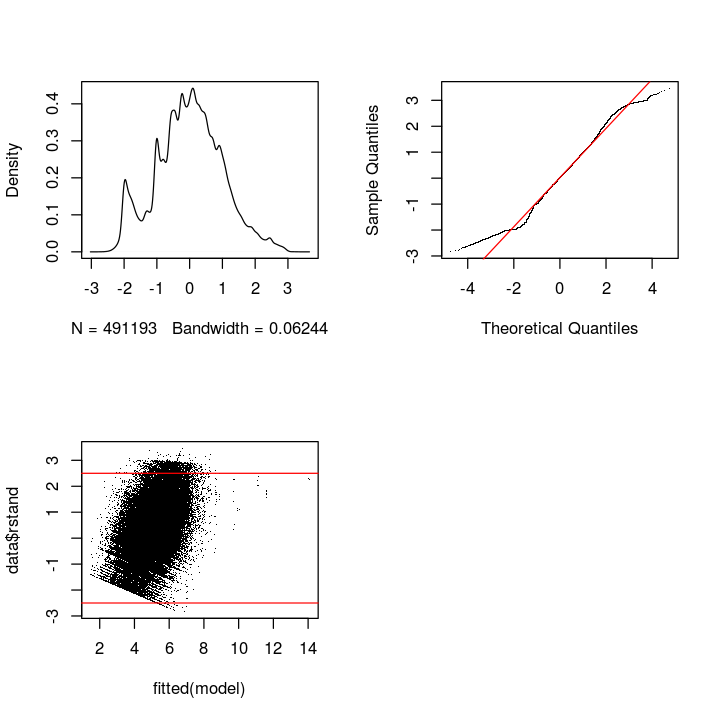

In [63]:
mcp.fnc(m2_limit)

What happens is that the residual diagnostics look better (expected). The effect of the session length is again positive (not changed) but a bit stronger.